# Single Point - End-to-End learning - Multilevel Diffractive Lens

Neerja Aggarwal

Aug 2nd, 2021

Purpose: Incorporate the physics of the Multilevel Diffractive Lens in place of the Diffractive Optic.  Run End to End with Gaussian input.

Start setting up the variables that are relevant.  Import pytorch

In [8]:
import torch
import torchvision
import torch.fft
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

device_no = 1 #CHANGE THIS TO WHICHEVER GPU YOU WANT TO USE
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device_no))
#device = 'cpu'  #ACTIVATE TO SWITCH TO GPU
print('Pytorch version')
print(torch.__version__)


NVIDIA TITAN X (Pascal)
Pytorch version
1.8.0+cu111


Establish data structures

In [9]:

#set spectral channels
numChannels = 10
wvstart = 800e-9
wvend = 900e-9
wvvec = np.linspace(wvstart,wvend,numChannels)
wvres = (wvend-wvstart)/numChannels
print('Wavelength Resolution is {0} nm'.format(wvres*1e9))

#set simulation size and spatial resolution
z = 1 # propagation distance [m]
l = 1e-3 # feature size
Nf = np.power((l/2),2)/(wvstart*z)
print('Fresnel Number equals {0}'.format(Nf))
aliasLvl = 1e-4
M = 100 #how many points to sample the feature with
Q = 100 #scale factor between feature and surrounding
N = Q*M #total number of sampling points. 
deltax = l/M 
print('DeltaX is {0} mm with {1} points'.format(deltax*1e3,N))


Wavelength Resolution is 10.0 nm
Fresnel Number equals 0.3125
DeltaX is 0.01 mm with 10000 points


Establish learnable parameters

In [18]:
#8 bit tensor with 1xN entries to represent the diffractive optic

def createAperture(M,N,maxheight=1, lowheight = 0):
    aperture = np.ones((N))*lowheight
    center = int(N/2)
    edge = int(M/2)
    aperture[center-edge:center+edge+1] = maxheight
    return aperture

def uniformOptic(N,height = 1):
    transmission = np.ones((N))*height
    return torch.tensor(transmission)

def createUniformMDL(N):
    #for now assume that detlax is bigger than the minfeature size. maxheight = 1.5e-6, minfeature = 2.5e-6
    #create a uniform height profile at 500 nm
    MDLheight = uniformOptic(N,500e-9)
    return MDLheight
    

do = createAperture(M,N,maxheight = 1.5e-6, lowheight = 0) #just use the full range why not

dotensor = torch.tensor(do)
dotensor.requires_grad = True


In [27]:
# diffractive optic is tensor that requires grads

def createHTransferFunc(deltax,N, z, lam): #create transfer function for free space propagation
    delfx = 1/(-deltax*N/2)
    fxvec = np.arange(-delfx*N/2,delfx*N/2,delfx)
    H = np.exp(1j*2.0*np.pi/lam*z)*np.exp(-1j* np.pi*lam*z*(np.power(fxvec,2)))
    H = np.array(H)
    Htensor = torch.tensor(H)
    return Htensor

def heightToPhase(lam, surfaceheight, indexRefraction = 1.6):
    phaseMap = surfaceheight*indexRefraction/lam
    return phaseMap

def throughDiffractiveLens(lam, surfaceheight,inputWave): #calculate wavefield after Diffractive Lens
    #surfaceheight and inputwave are both tensors
    phaseMap = heightToPhase(lam,surfaceheight)
    #wave after diffractive Optic
    diffractiveOpticWave = torch.mul(phaseMap, inputWave)
    return diffractiveOpticWave

def FresnelForward(lam, z, diffractiveOptic, H): # run light through freespace
    doFFT = torch.fft.fft(diffractiveOptic)
    doFFT2 = torch.fft.fftshift(doFFT)
    yfft = doFFT2*H
    y = torch.fft.fft(yfft)
    return y

Check forward model

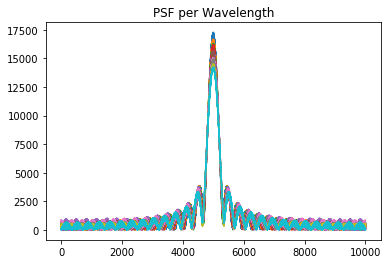

In [28]:
#create PSF matrix

def createPSFmatrix(N,numChannels,wvvec,deltax,z, dotensor, pltgrph = False):
    PSFtensor = torch.empty((N,numChannels), dtype=torch.float64)  #need to specify as float64 to avoid "double" error later
    inputWave = uniformOptic(N,1)

    if pltgrph:
        plt.figure()
    for k in np.arange(numChannels):
        lam = wvvec[k]
        doWave = throughDiffractiveLens(lam,dotensor,inputWave)
        H = createHTransferFunc(deltax, N, z, lam)
        meas = FresnelForward(lam, z, doWave, H)
        y = torch.abs(meas) #make sure it is still differentiable!
        PSFtensor[:,k] = y #keep grads
        if pltgrph:
            plt.plot(y.detach())
            plt.title('PSF per Wavelength')
    if pltgrph:
        plt.show()
    return PSFtensor

PSFtensor = createPSFmatrix(N,numChannels,wvvec,deltax,z,dotensor,pltgrph = True)

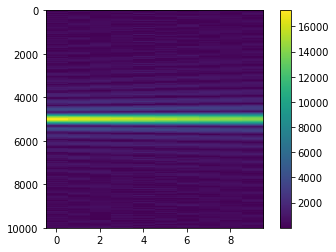

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
PSFnp = PSFtensor.detach().numpy()
pos = ax.imshow(np.asarray(PSFnp))
ax.set_aspect(numChannels/N)
fig.colorbar(pos, ax=ax)

Write reconstruction code:

Text(0, 0.5, 'Intensity')

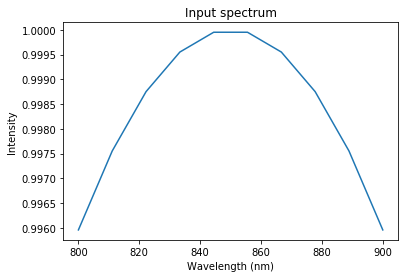

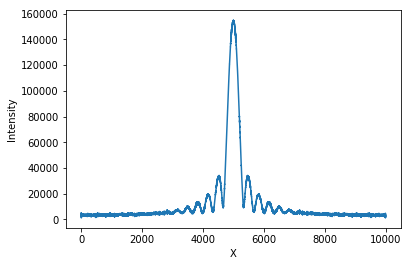

In [30]:

def inputGaussian(std = 5,pltgrph=False):
    inputspectra = signal.gaussian(numChannels,std)
    inputTensor = torch.tensor(inputspectra)
    if pltgrph:
        plt.figure()
        plt.plot(wvvec*1e9,inputspectra)
        plt.title('Input spectrum')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity')
    return inputTensor

inputTensor = inputGaussian(50, pltgrph=True)
    
def ForwardModel(x,A): 
    y =  torch.matmul(A,x)
    return y

inputTensor.dtype

measurement = ForwardModel(inputTensor,PSFtensor)
ytrue = measurement
plt.figure()
plt.plot(measurement.detach())
plt.xlabel('X')
plt.ylabel('Intensity')

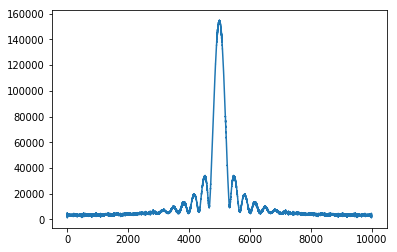

In [31]:
def addNoise(measurement, SNR,pltgrph=False):
    mMean = torch.sum(measurement)/N/SNR
    noise = np.random.normal(0,mMean.detach().numpy(),N)
    noisetensor = torch.tensor(noise)
    noisymeasurement = torch.add(measurement,noisetensor)
    if pltgrph:
        plt.figure()
        plt.plot(noisymeasurement.detach())
    return noisymeasurement

ytrue = addNoise(measurement,1e4,pltgrph=True)



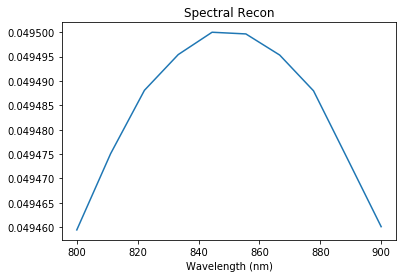

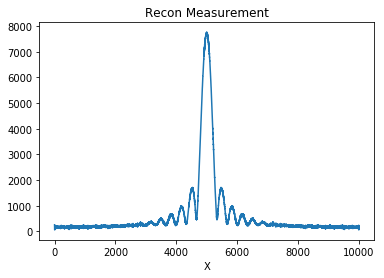

tensor(1.2153e+08, dtype=torch.float64, grad_fn=<SumBackward0>)


In [32]:
def PseudoInverse(error, A):
    At = torch.transpose(A,0,1)
    AtA = torch.matmul(At,A)
    invA = torch.linalg.inv(AtA)
    gradDir = torch.matmul(invA,At)
    xgrad = torch.matmul(gradDir,error)
    return xgrad

def softthr(x, thr):
    # softthr - Soft thresholding operator
    # args in -
    #   x - input vector
    #   thr - shrinkage threshold
    # args out - 
    #   z - output vector
    z = torch.abs(x) - thr
    z = z * torch.sign(x) * (torch.abs(x) > thr)
    return z

def runRecon(PSFtensor,ytrue, numIter=100, pltgrph = False, lambda0 = 1e0,pltevery = 100):
    initSpectra = np.ones(numChannels)*0.05
    x = torch.tensor(initSpectra)
    stepSize = 1e-2
    A = PSFtensor

    for iter in np.arange(numIter):
        ym = ForwardModel(x,A)
        error = ytrue-ym
        grads = PseudoInverse(error,A)
        x = torch.add(x,stepSize*grads) #gradient update. #need to add proximal update (later)?
        x[x<0] = 0 #nonegativity #proximal update.
        x = softthr(x, lambda0*stepSize)   # proximal update

        #print(np.sum(error))
        if pltgrph:
            if iter%pltevery==0:
                plt.figure()
                plt.plot(wvvec*1e9,x.detach())
                plt.title('Spectral Recon')
                plt.xlabel('Wavelength (nm)')
                plt.figure()
                plt.plot(ym.detach())
                plt.title('Recon Measurement')
                plt.xlabel('X')
                plt.show()
    print(torch.sum(error))
    return x

x = runRecon(PSFtensor,ytrue, pltgrph = True,numIter=100)

Calculate the loss function

In [33]:
loss = x-inputTensor
loss_dc = torch.sum(loss**2) #need it to be the square
print(loss_dc)

tensor(9.6255, dtype=torch.float64, grad_fn=<SumBackward0>)


Update the diffractive optics design

In [34]:
g = torch.autograd.grad(loss_dc,dotensor)
print(g[0])

tensor([-0.0485,  1.6685,  0.5274,  ..., -0.1245, -0.7024, -1.3883],
       dtype=torch.float64)


In [35]:
alpha = 1e-3
dotensor = dotensor - alpha*g[0]

In [36]:
do1 = dotensor.detach().numpy()

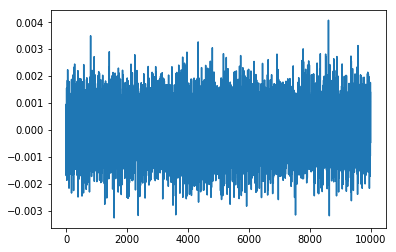

In [37]:
plt.plot(do1-do)

## Now write as a big for loop to do iterative updating

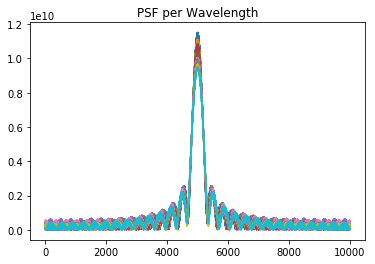

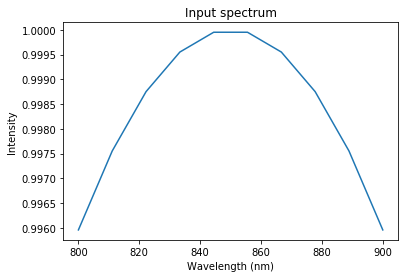

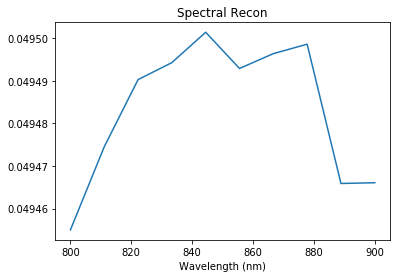

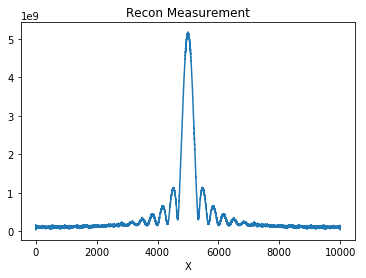

tensor(8.1017e+13, dtype=torch.float64, grad_fn=<SumBackward0>)


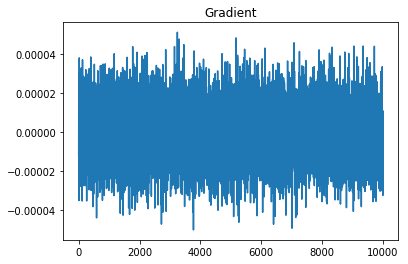

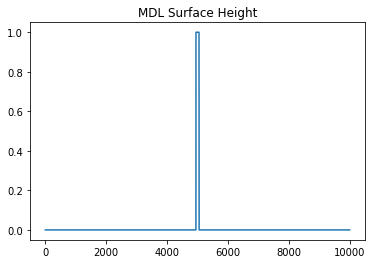

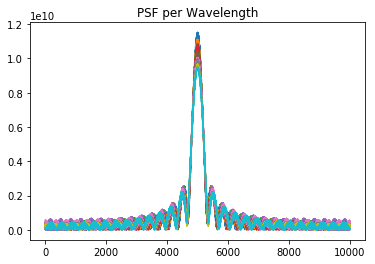

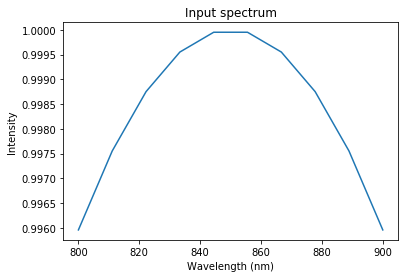

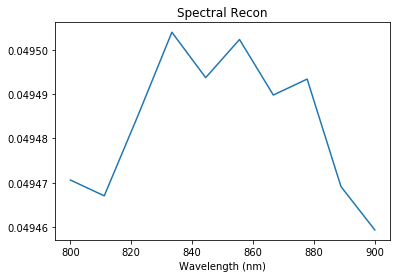

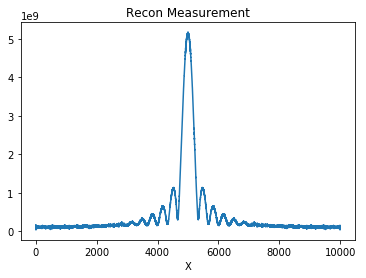

tensor(8.1019e+13, dtype=torch.float64, grad_fn=<SumBackward0>)


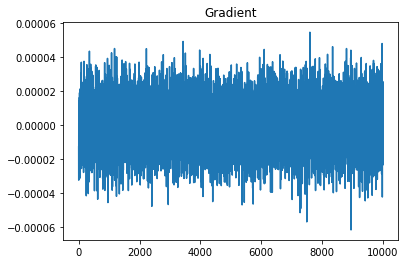

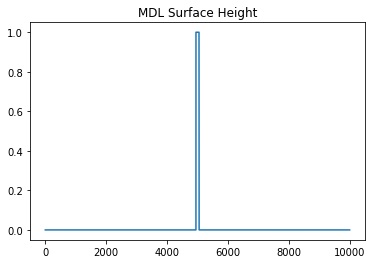

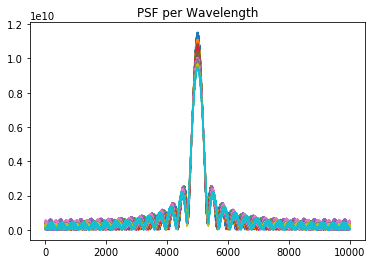

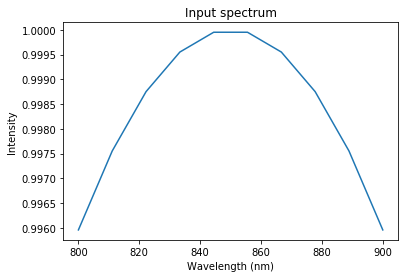

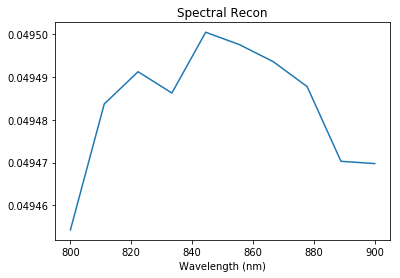

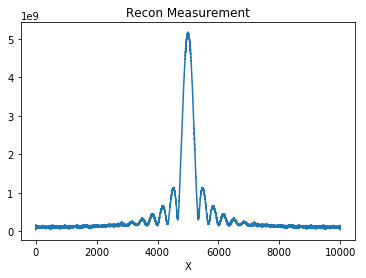

tensor(8.1017e+13, dtype=torch.float64, grad_fn=<SumBackward0>)


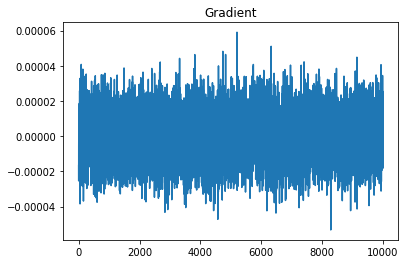

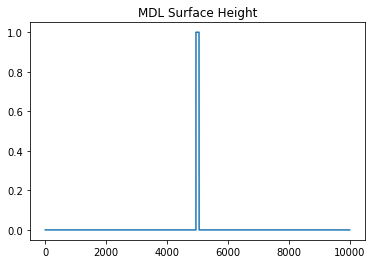

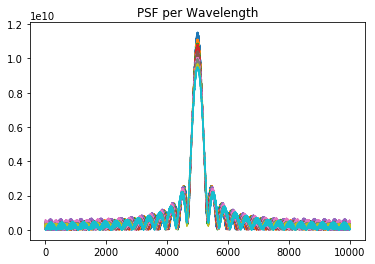

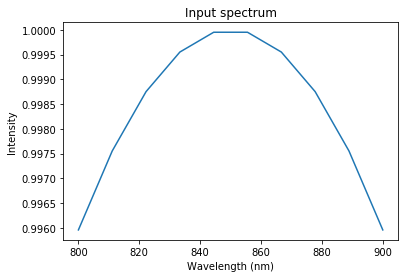

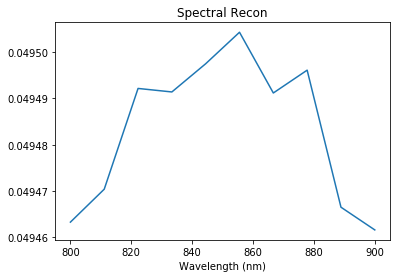

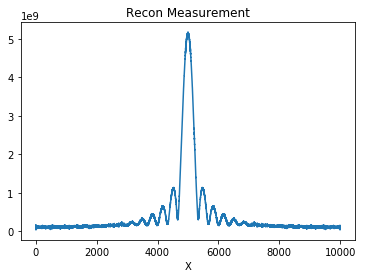

tensor(8.1018e+13, dtype=torch.float64, grad_fn=<SumBackward0>)


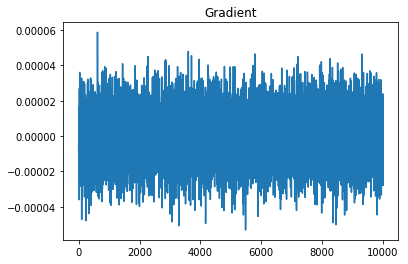

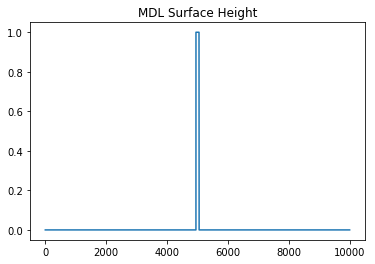

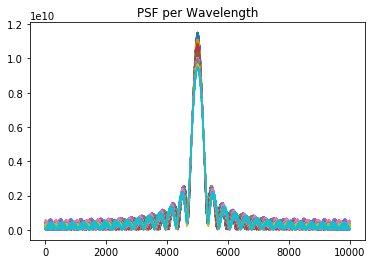

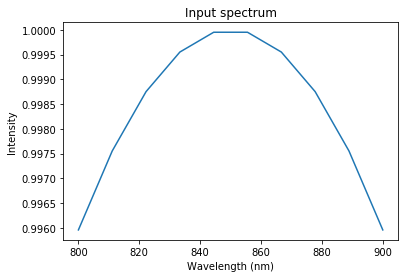

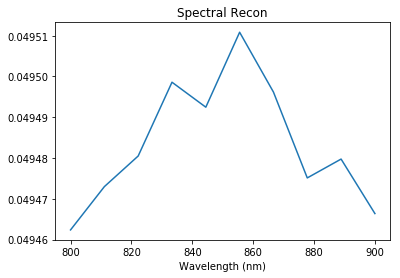

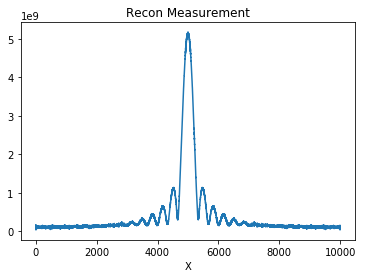

tensor(8.1017e+13, dtype=torch.float64, grad_fn=<SumBackward0>)


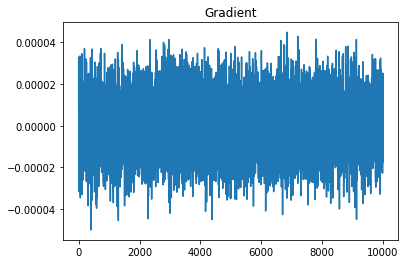

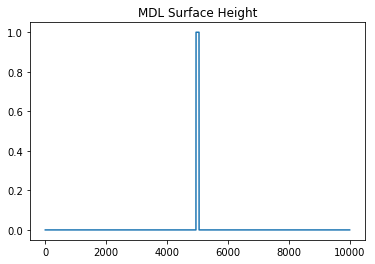

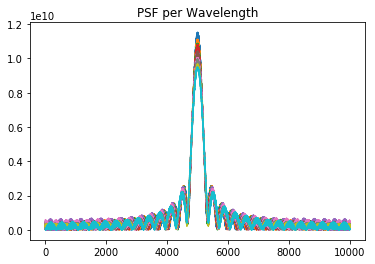

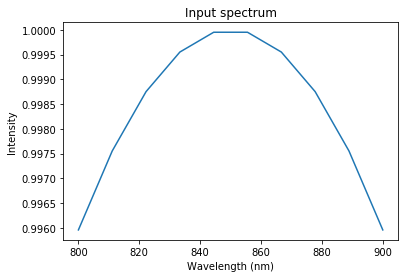

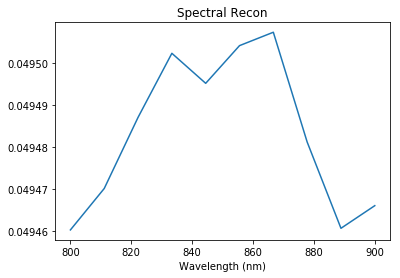

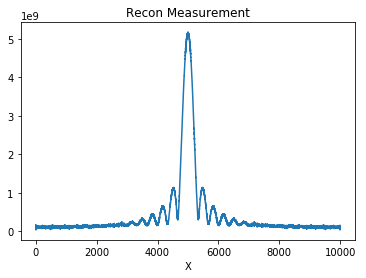

tensor(8.1018e+13, dtype=torch.float64, grad_fn=<SumBackward0>)


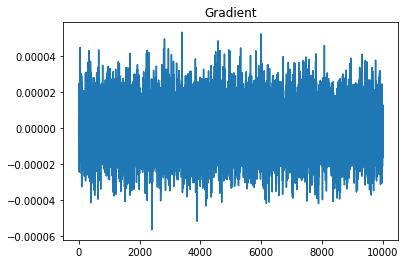

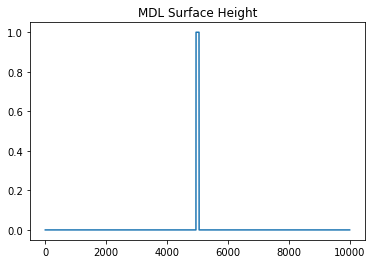

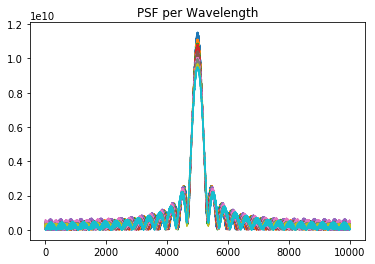

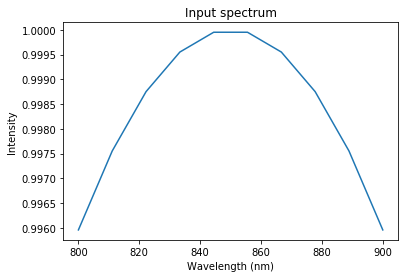

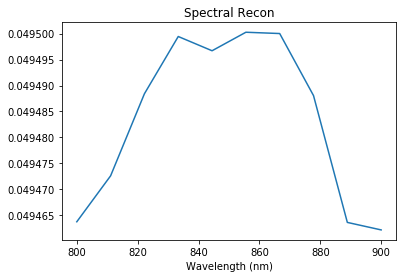

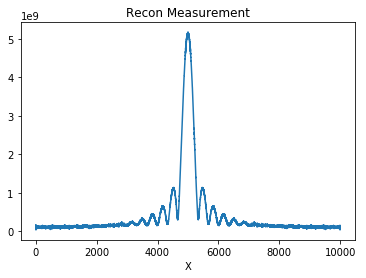

tensor(8.1018e+13, dtype=torch.float64, grad_fn=<SumBackward0>)


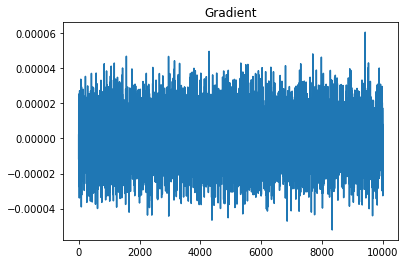

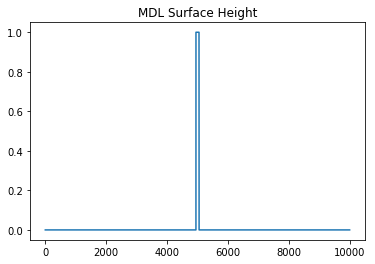

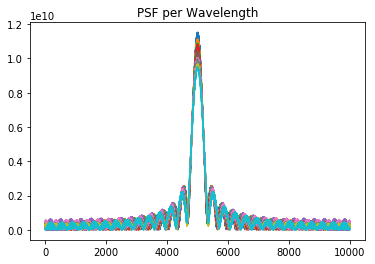

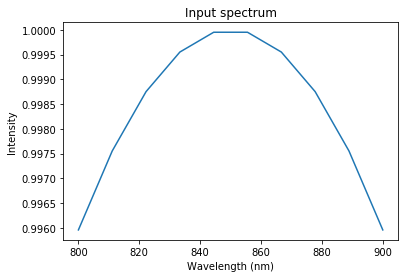

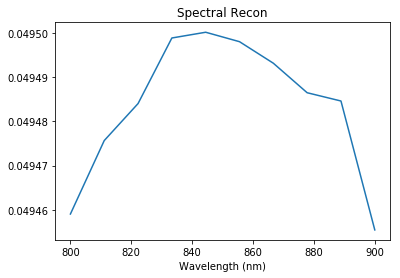

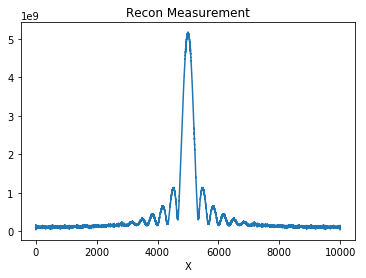

tensor(8.1018e+13, dtype=torch.float64, grad_fn=<SumBackward0>)


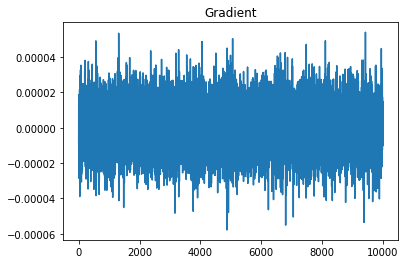

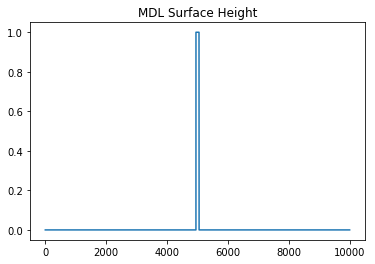

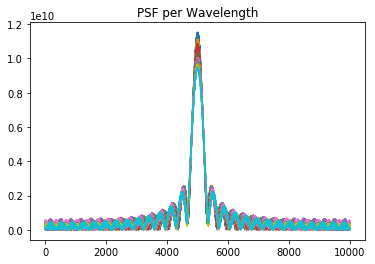

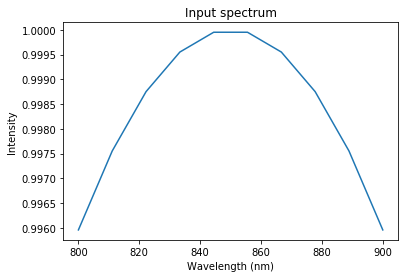

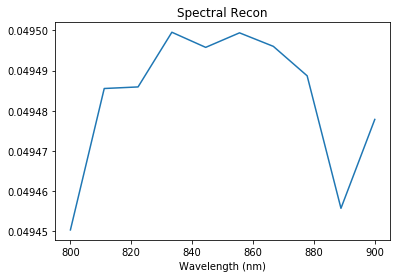

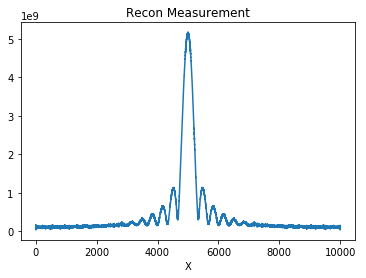

tensor(8.1016e+13, dtype=torch.float64, grad_fn=<SumBackward0>)


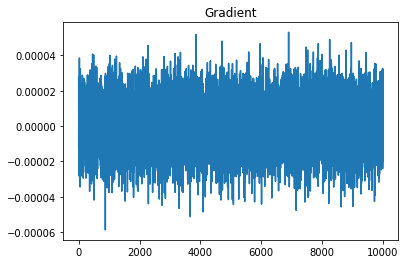

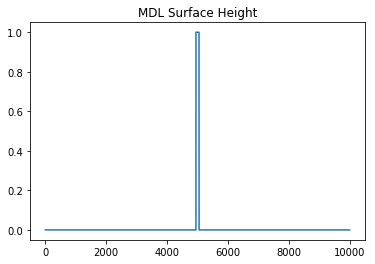

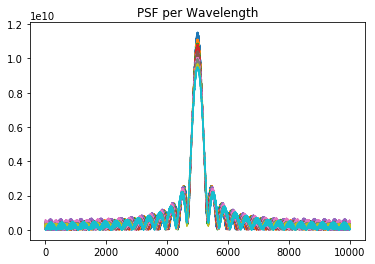

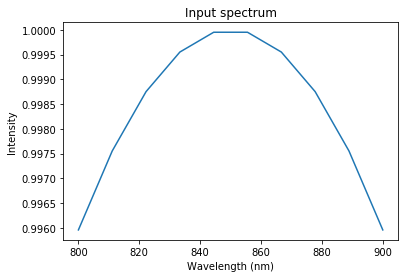

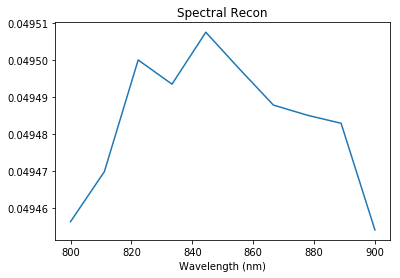

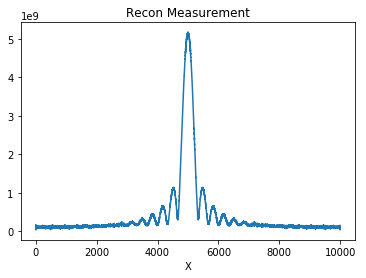

tensor(8.1017e+13, dtype=torch.float64, grad_fn=<SumBackward0>)


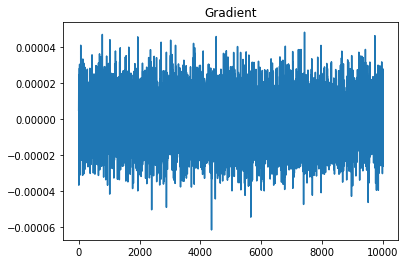

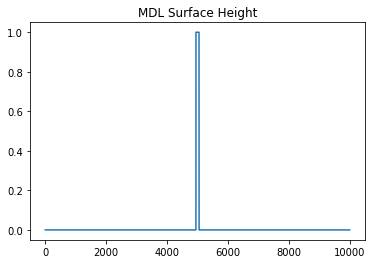

In [40]:
# initialize outloop variables
numIterDO = 10

do = createAperture(M,N)
dotensor = torch.tensor(do)
dotensor.requires_grad = True

alpha = 1e-1 #learning rate
lambda1 = 1e-2 #softthreshold parameter

def softthr(x, thr):
    # softthr - Soft thresholding operator
    # args in -
    #   x - input vector
    #   thr - shrinkage threshold
    # args out - 
    #   z - output vector
    z = torch.abs(x) - thr
    z = z * torch.sign(x) * (torch.abs(x) > thr)
    return z

losslist = []
for k1 in np.arange(numIterDO):
    
    #create system matrix
    PSFtensor = createPSFmatrix(N,numChannels,wvvec,deltax,z,dotensor,pltgrph = True)
    
    #create input data to test - or use SGD here
    inputTensor = inputGaussian(50, pltgrph=True)
    #get output through current system
    measurement = ForwardModel(inputTensor,PSFtensor)
    #add noise to the measurement as needed
    ytrue = addNoise(measurement, 1e3)
    #try the recon
    x = runRecon(PSFtensor,ytrue, pltgrph = True, numIter = 100)
    #use the recon error to update the diffractive optic
    
    loss = x-inputTensor
    loss_dc = torch.sum(loss**2) #need it to be the square
    g = torch.autograd.grad(loss_dc,dotensor)
    dotensor = dotensor - alpha*g[0]  #gradient update
    dotensor[dotensor<0] = 0 #nonnegativity update
    #dotensor = softthr(dotensor, lambda1*alpha)   # proximal update
    
    with torch.no_grad():
        loss = loss_dc + lambda1 * torch.sum(torch.abs(x))
        losslist.append(loss.detach().numpy())
    plt.figure()
    plt.plot(g[0].detach().numpy())
    plt.title('Gradient')
    plt.figure()
    plt.plot(dotensor.detach().numpy())
    plt.title('MDL Surface Height')
    
    

In [2]:
plt.plot(dotensor.detach().numpy())


NameError: name 'plt' is not defined